<a href="https://colab.research.google.com/github/maengg/Customer_churn/blob/main/Customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **데이터 설명**

*데이터 셋은 kaggle의 [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) 데이터셋으로 3분기에 캘리포니아의 7043명의 고객에게 집 전화 및 인터넷 서비스를 제공한 가상의 통신 회사에 대한 정보를 담고 있다. <br>
(데이터의 형태는 7043 rows, 21 columns)*

<br>

### **각 column 설명**

* gender : 고객의 성별
* SeniorCitizen : 고객이 65세 이상인지 아닌지 (Yes : 1, No : 0)
* Dependents : 고객이 부양가족과 함께 살고 있는지, 부양가족은 자녀, 부모, 조부모 등이 될 수 있다. (Yes , No)
* Partner : 결혼 여부(Yes ,No)
* tenure : 누적 이용 기간 (단위 : 월)
* PhoneService : 고객이 집 전화 서비스에 구독했는지 여부 (Yes ,No)
* MultipleLines : 고객이 여러 전화선에 구독했는지 여부 (Yes, No, No phone service)
* InternetService : 고객이 인터넷 서비스에 구독했는지 여부 (No, DSL, Fiber optic)
* OnlineSecurity : 고객이 온라인 보안 서비스에 구독했는지 여부 (Yes, No, No internet service)
* OnlineBackup : 고객이 온라인 백업 서비스를 구독했는지 여부 (Yes, No, No internet service)
* DeviceProtection : 고객이 추가 장치 보호 요금제에 가입했는지 여부 (Yes, No, No internet service)
* TechSupport : 고객이 줄어든 대기시간으로 추가 기술 지원 요금제에 가입했는지 여부 (Yes, No, No internet service)
* StreamingTV : 고객이 TV 스트리밍을 이용하는지 여부 (Yes, No, No internet service) 
* StreamingMovies : 고객이 영화 스트리밍을 이용하는지 여부 (Yes, No, No internet service)
* Contract : 고객의 현재 계약 유형 (Month-to-month(월간), One year(1년), Two year(2년))
* PaperlessBilling : 고객이 전자명세서를 선택했는지
* PaymentMethod : 고객이 청구서를 지불하는 방법 (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* MonthlyCharges : 월별 납부 금액
* TotalCharges : 누적 납부 금액
* Churn : 이탈 여부 (Yes, No), Target data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 라이브러리 불러오기.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 style white로 설정.
sns.set(style = 'white')

# FutureWarning 무시
import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# 데이터 불러오기.
df_original = pd.read_csv('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
# 데이터셋 확인.
print('Data shape :', df_original.shape)
df_original.head()


Data shape : (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# 원본 데이터 보호를 위해 데이터 copy
df = df_original.copy()
df.shape

(7043, 21)

# **EDA**

In [6]:
# 각 컬럼별 데이터 타입이 알맞은지 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# TotalCharges의 경우 숫자형 데이터인데 object로 되어있기에, 확인 필요.
# 최빈값이 ' '로 총 11개의 데이터가 공백으로 처리되어 있음을 확인.
df['TotalCharges'].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

In [8]:
# 공백으로 처리된 데이터 확인.
# tenure가 0이다. 즉, 아직 가입한지 한달이 지나지 않은 고객들
df[df['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [9]:
# TotalCharges 숫자형으로 바꾸고 빈 공백은 결측치로 처리. 즉, 가입한지 한달이 안된 고객은 결측치로 처리.
# 고객 이탈 분석이라는 목적에 가입한지 한달이 안된 고객은 부적절한 데이터라고 판단하여 삭제 후 결측치 확인.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
# 중복 데이터 확인
print(f'데이터에서 중복 데이터는 총 {df.duplicated().sum()}개 입니다.')

데이터에서 중복 데이터는 총 0개 입니다.


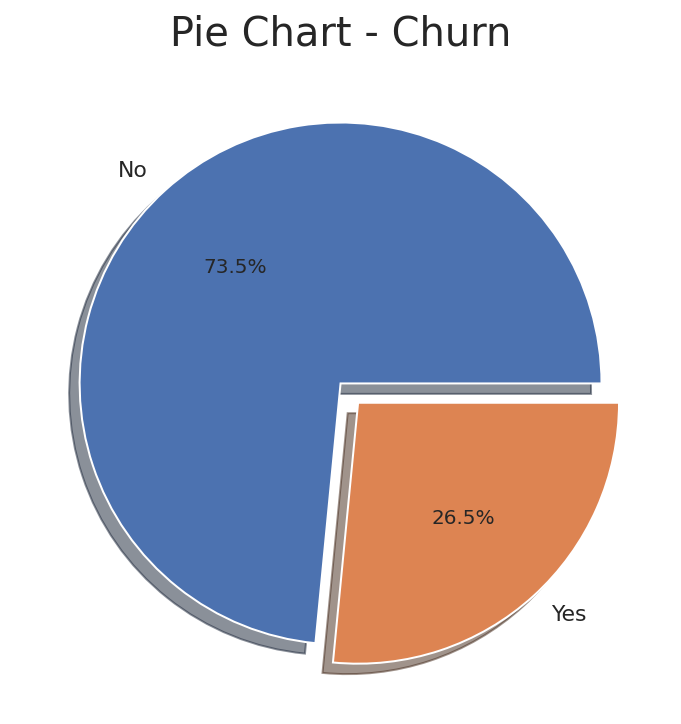

In [11]:
# 타겟 데이터 확인

# pie 차트
plt.figure(figsize=(10,6))
df_original['Churn'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%', shadow=True)
plt.title('Pie Chart - Churn', fontsize=20)
plt.ylabel('')

plt.show()

In [12]:
# Churn 특성 No => 0, Yes =>1

df['Churn'].replace({'No' : 0, 'Yes' : 1}, inplace=True)

**어느정도 불균형이 있는 걸 확인**

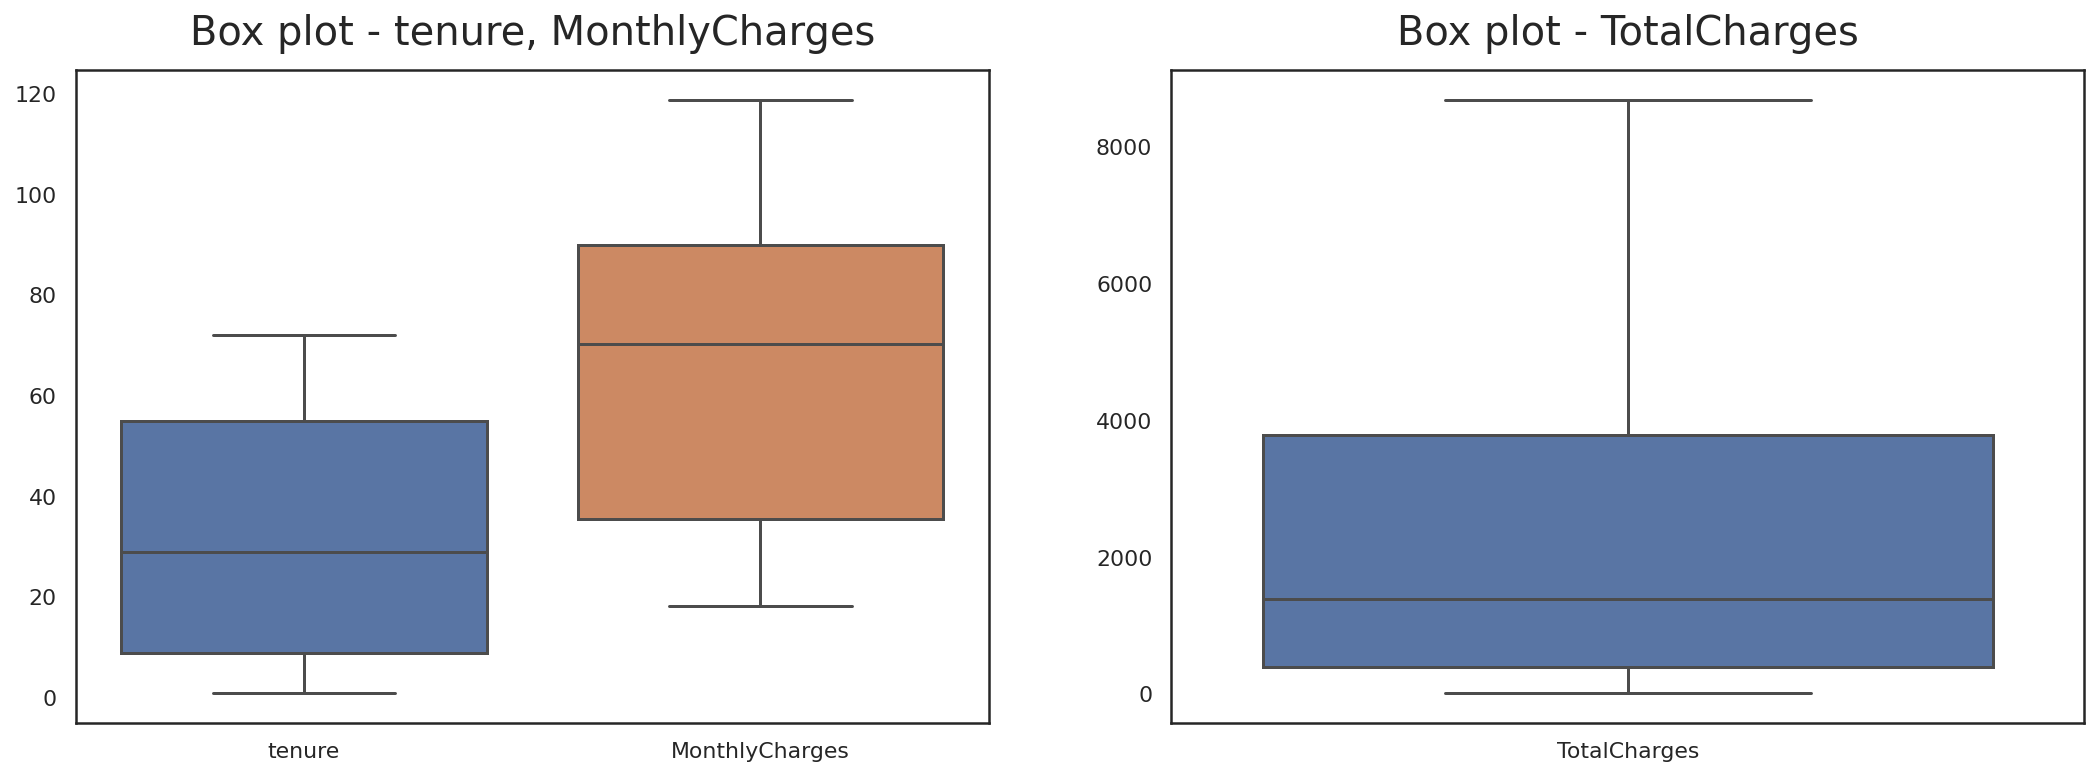

In [13]:
# boxplot으로 이상치 확인.

fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.boxplot(data=df[['tenure','MonthlyCharges']], ax=ax[0])
ax[0].set_title('Box plot - tenure, MonthlyCharges', fontsize=20, y=1.02)

sns.boxplot(data=df[['TotalCharges']], ax=ax[1])
ax[1].set_title('Box plot - TotalCharges',fontsize=20, y=1.02)

plt.show()

**연속형 데이터에서 이상치 없는 것 확인.**

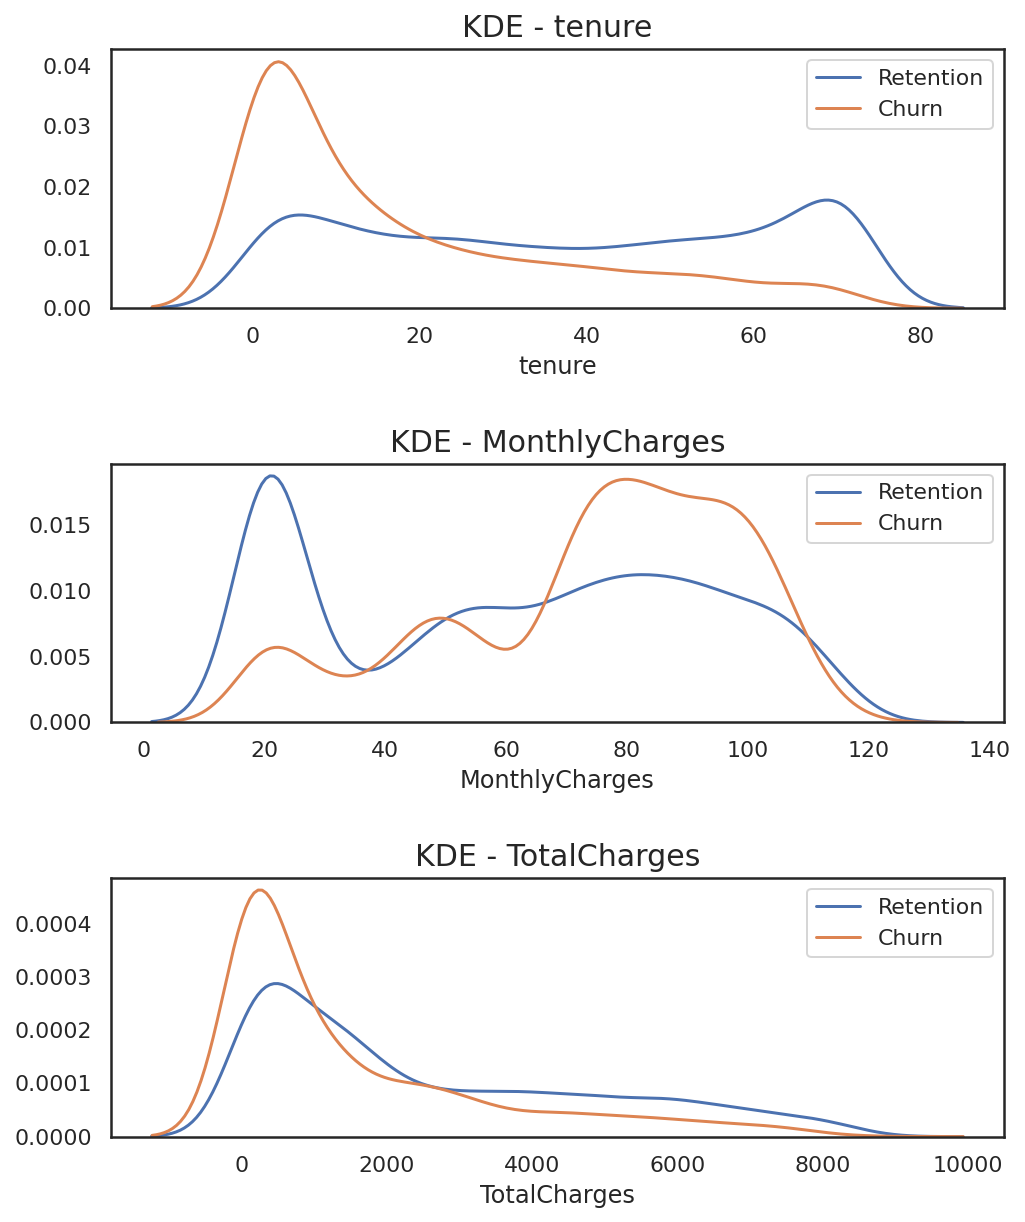

In [14]:
# 연속형 데이터 확률밀도함수 그래프

fig, ax = plt.subplots(3,1,figsize=(8,10))

sns.kdeplot(df[df['Churn'] == 0]['tenure'], ax=ax[0])
sns.kdeplot(df[df['Churn'] == 1]['tenure'], ax=ax[0])
ax[0].set_title('KDE - tenure', fontsize=15)
ax[0].legend(['Retention', 'Churn'])
ax[0].set_ylabel('')

sns.kdeplot(df[df['Churn'] == 0]['MonthlyCharges'], ax=ax[1])
sns.kdeplot(df[df['Churn'] == 1]['MonthlyCharges'], ax=ax[1])
ax[1].set_title('KDE - MonthlyCharges', fontsize=15)
ax[1].legend(['Retention', 'Churn'])
ax[1].set_ylabel('')

sns.kdeplot(df[df['Churn'] == 0]['TotalCharges'], ax=ax[2])
sns.kdeplot(df[df['Churn'] == 1]['TotalCharges'], ax=ax[2])
ax[2].set_title('KDE - TotalCharges',fontsize=15)
ax[2].legend(['Retention', 'Churn'])
ax[2].set_ylabel('')

plt.subplots_adjust(hspace=0.6)
plt.show()

### **확률밀도함수로 알 수 있는 것.**

1. 누적 가입기간이 짧을 수록 이탈할 확률이 높다.
2. 월 요금이 약 20달러인 경우 고객이 잘 유지되나, 약 65~110달러로 높아지면 이탈할 확률이 높아진다.
3. 누적요금 변수는 이탈에 큰 영향을 끼친다고 보기는 어려움.



## **고객의 상태와 관련된 특성들**

*gender, SeniorCitizen, Partner,Dependents*

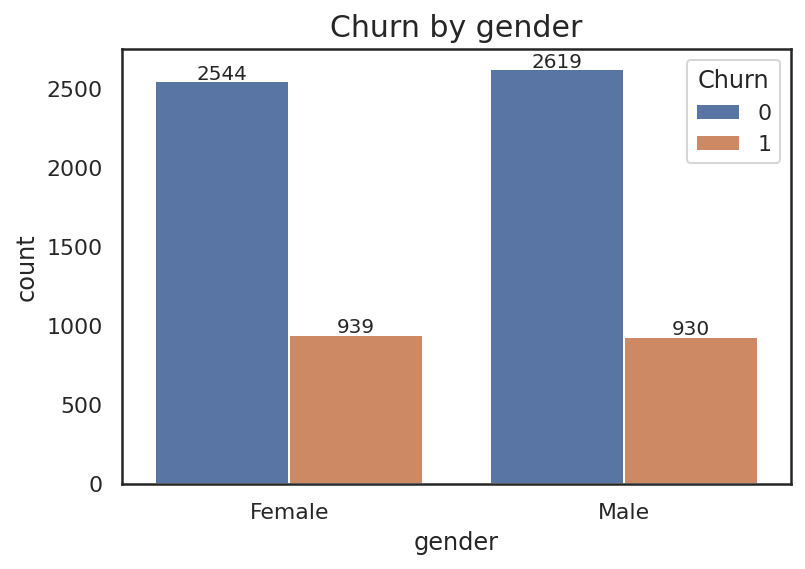

In [15]:
# gender 별 이탈 정도 확인.
ax = sns.countplot('gender', hue='Churn', data=df)
ax.set_title('Churn by gender', fontsize=15)

# 각각의 바 위에 값 추가.
for p in ax.patches:
  ax.text(p.get_x()+p.get_width()/2., p.get_height()+15, p.get_height(), ha='center', size=10)

plt.show()

**성별이 이탈에 큰 영향을 끼친다고 보기는 힘들다.**

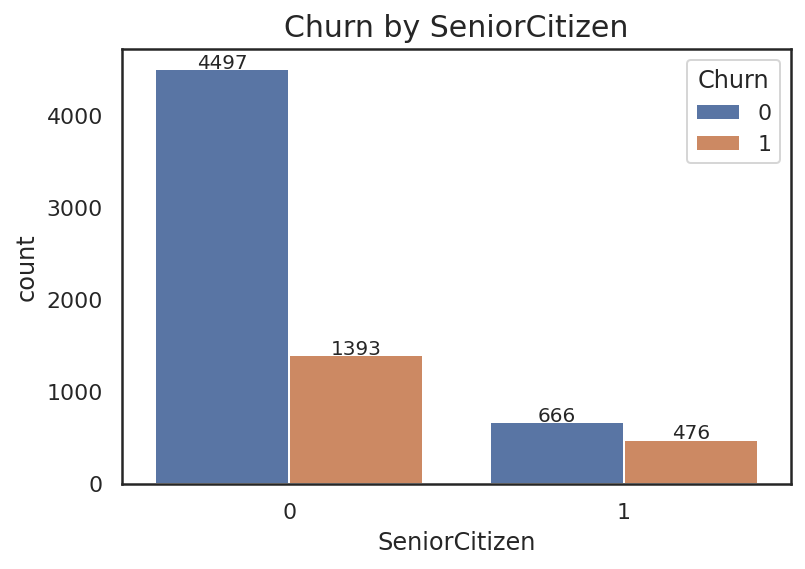

In [16]:
# 고객의 연령에 따른 이탈 정도

ax = sns.countplot('SeniorCitizen', hue='Churn', data=df)
ax.set_title('Churn by SeniorCitizen', fontsize=15)

for p in ax.patches:
  ax.text(p.get_x()+p.get_width()/2., p.get_height()+15, p.get_height(), ha='center', size=10)

plt.show()

**65세 이상인 경우 이탈이 더 많은 것 같지만 정도를 확인하기 위해 퍼센테이지로도 확인**

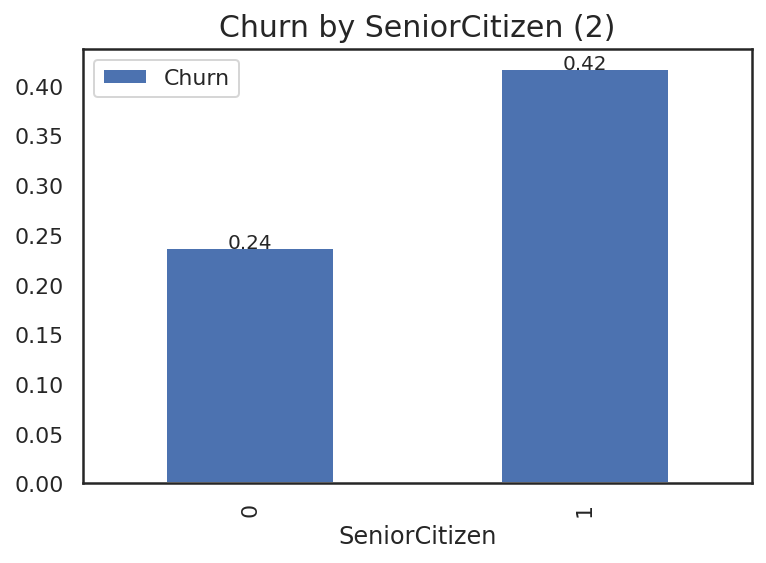

In [17]:
# 연령별 이탈 정도를 퍼센테이지로 한번 더 확인

ax = df[['SeniorCitizen', 'Churn']].groupby('SeniorCitizen', as_index=True).mean().plot.bar()
ax.set_title('Churn by SeniorCitizen (2)', fontsize=15)

for p in ax.patches:
  ax.text(p.get_x()+p.get_width()/2., p.get_height(), f'{p.get_height():.2f}', ha='center', size=10)

plt.show()

**65세 이상인 경우 이탈률이 42%로 65세 미만인 경우의 24% 보다 더 높은 것을 확인할 수 있다.**

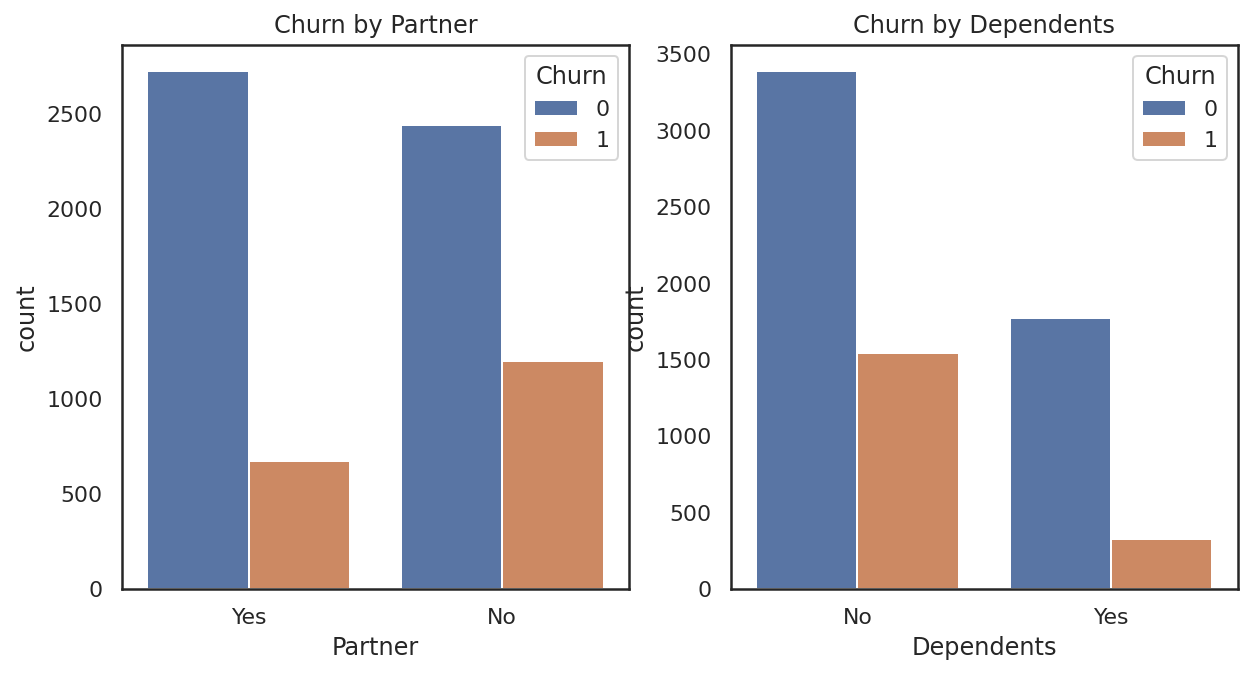

In [18]:
# Partner, Dependents

fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.countplot('Partner', hue='Churn', data=df, ax=ax[0])
ax[0].set_title('Churn by Partner')

sns.countplot('Dependents', hue='Churn', data=df, ax=ax[1])
ax[1].set_title('Churn by Dependents')

plt.show()

**파트너가 있는 경우, 부양가족이 있는 경우에 이탈 고객이 더 적다**

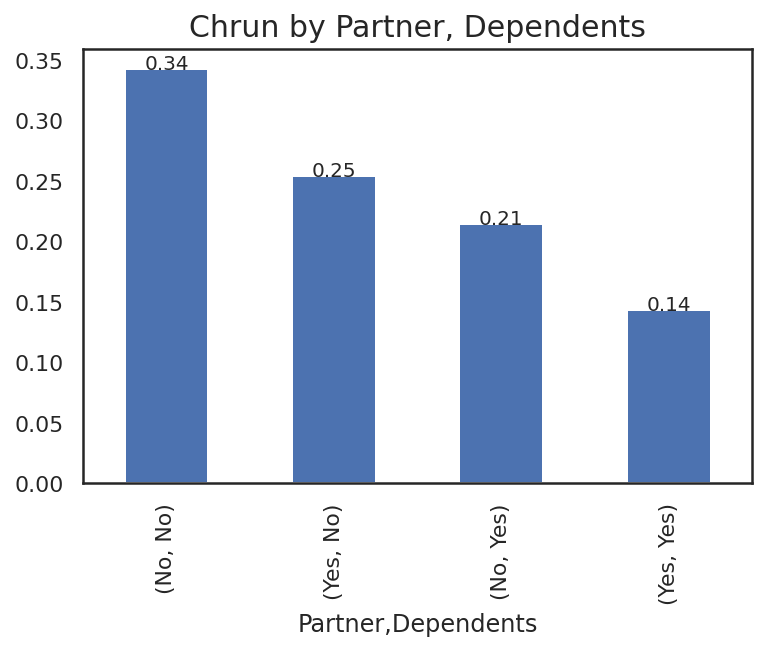

In [19]:
ax = df.groupby(['Partner', 'Dependents'])['Churn'].mean().sort_values(ascending=False).plot.bar()
ax.set_title('Chrun by Partner, Dependents', fontsize=15)

for p in ax.patches:
  ax.text(p.get_x()+p.get_width()/2., p.get_height(), f'{p.get_height():.2f}', ha='center', size=10)
  
plt.show()

**혼자사는 경우 이탈률이 증가하고, 파트너도 있고 부양가족도 있는 즉, 가족과 함께 사는 경우 14%로 이탈률이 감소한다.**

**고객은 크게 세 분류로 분류할 수 있다.**

1. Phone service만 구독하는 고객.
2. Internet service만 구독하는 고객.
3. 둘다 구독하는 고객.

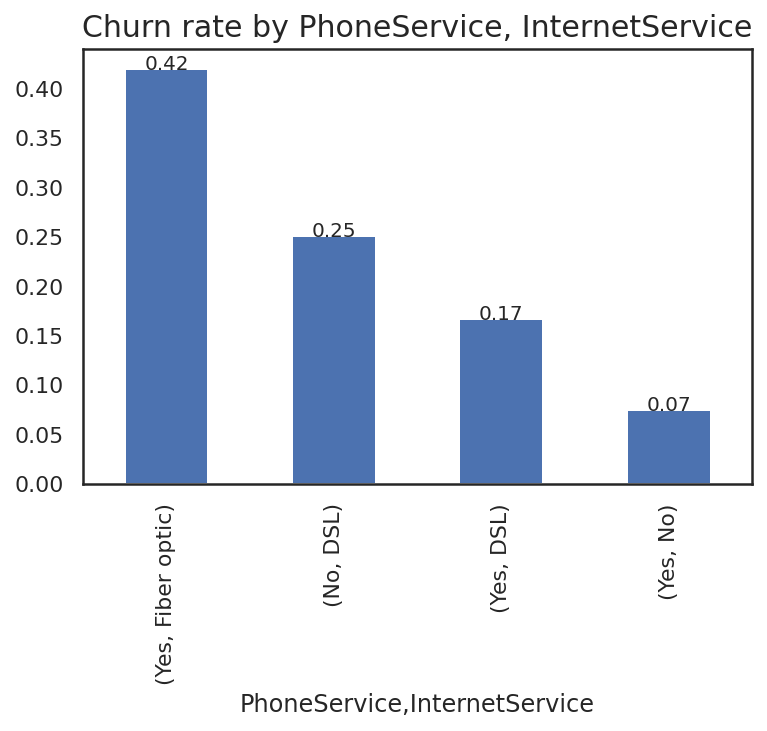

In [20]:
# 전화와 인터넷 서비스로 분류한 고객별 이탈률
ax = df.groupby(['PhoneService', 'InternetService'])['Churn'].mean().sort_values(ascending=False).plot.bar()
ax.set_title('Churn rate by PhoneService, InternetService', fontsize=15)

for p in ax.patches:
  ax.text(p.get_x()+p.get_width()/2., p.get_height(), f'{p.get_height():.2f}', ha='center', size=10)

In [21]:
# 각 고객이 총 고객에서 얼만큼의 비율을 차지하는지 확인.
phone_internet = df[['PhoneService', 'InternetService', 'Churn']].groupby(['PhoneService', 'InternetService']).count()
phone_internet['customer_ratio'] = phone_internet['Churn'] / len(df)
phone_internet

Churn  customer_ratio
PhoneService InternetService                       
No           DSL                680        0.096701
Yes          DSL               1736        0.246871
             Fiber optic       3096        0.440273
             No                1520        0.216155

전화 서비스와 인터넷 서비스 중 **Fiber optic(광섬유 인터넷)을 이용하는 고객의 비율이 전체 고객 중 44%로 많은데, 이탈률도 42%로 가장 높다.** 반면, **전화 서비스만 이용하는 고객의 이탈률은 7%로 매우 낮다.** 이를 통해 **인터넷 서비스에 고객들의 불만이 많을 것**이라고 예측해 볼 수 있다. 또한 **Fiber optic의 경우 타사에 비해 성능이나 가격적인 면에서 부족할 것**이라고 예측해 볼 수 있다.

DSL의 경우 전화 서비스를 사용하지 않고 **DSL 인터넷만을 이용하는 경우는 9%로 이탈률이 낮았지만, 전화 서비스와 함께 이용하는 경우 이탈률이 24%로 올라갔다.**

In [34]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


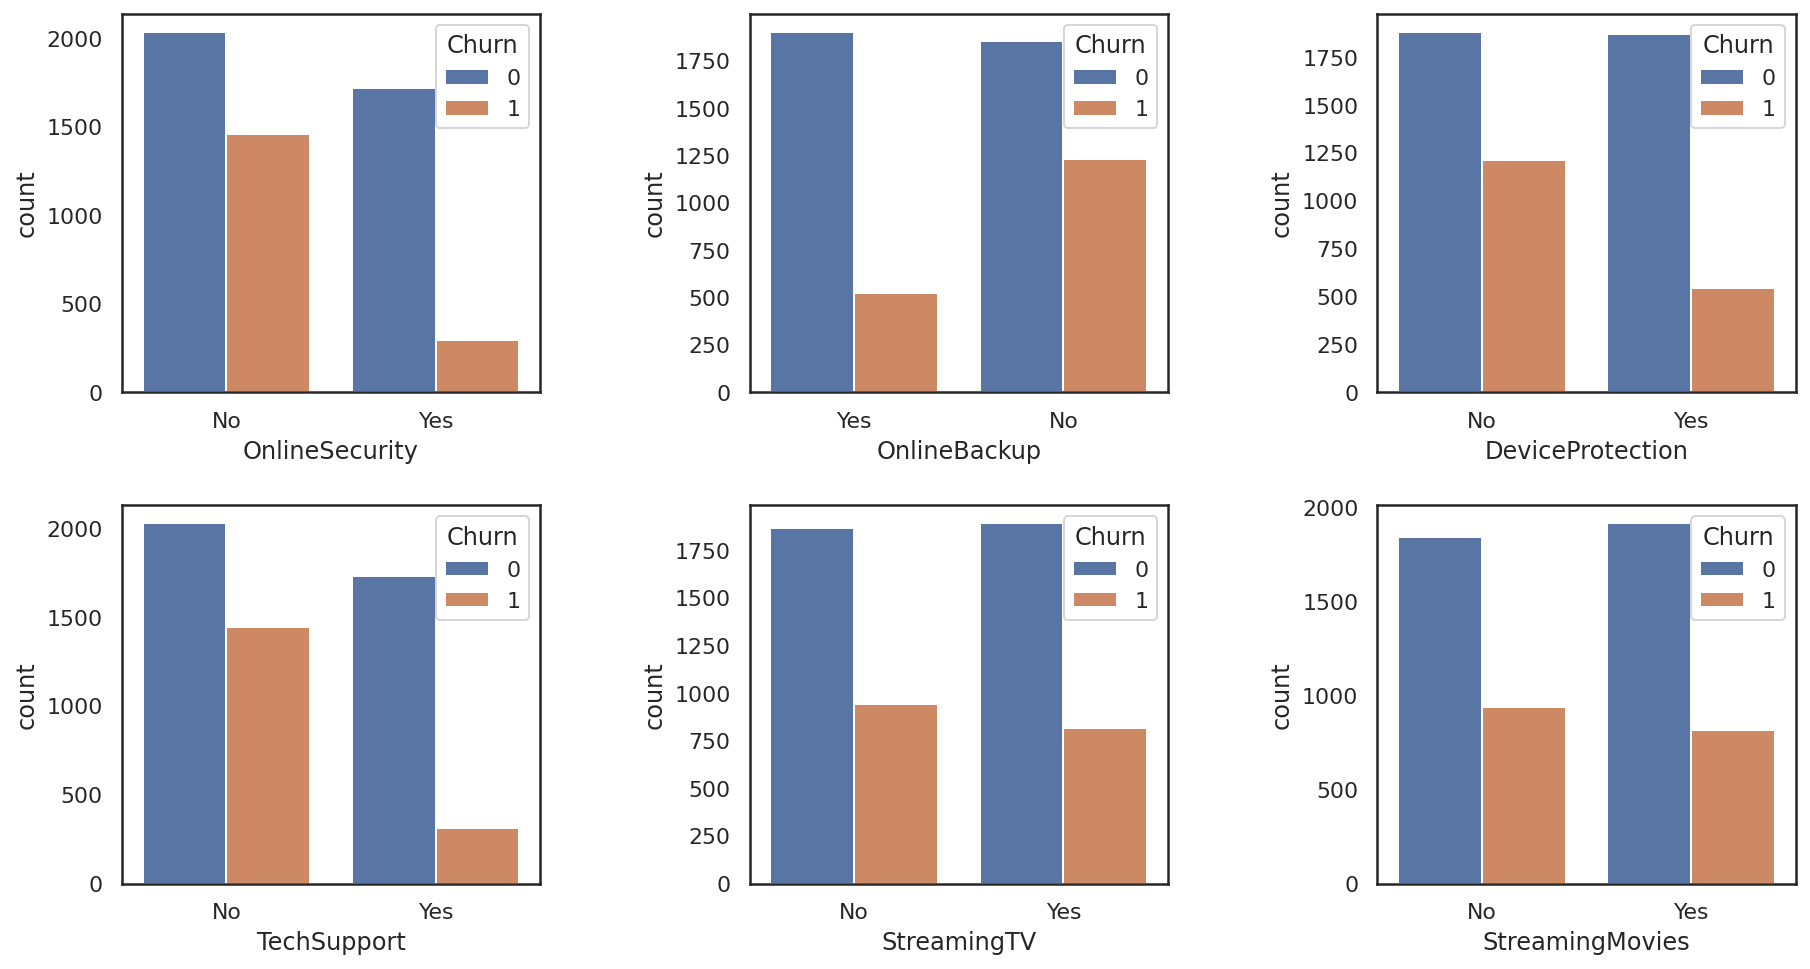

In [55]:
# 인터넷 서비스와 연동된 서비스

fig, ax = plt.subplots(2,3, figsize=(15,8))

# 인터넷 서비스에 가입하지 않은 경우는 제외.
sns.countplot('OnlineSecurity', hue='Churn', data=df[df['OnlineSecurity'] != 'No internet service'], ax=ax[0,0])
sns.countplot('OnlineBackup', hue='Churn', data=df[df['OnlineBackup'] != 'No internet service'], ax=ax[0,1])
sns.countplot('DeviceProtection', hue='Churn', data=df[df['DeviceProtection'] != 'No internet service'], ax=ax[0,2])
sns.countplot('TechSupport', hue='Churn', data=df[df['TechSupport'] != 'No internet service'], ax=ax[1,0])
sns.countplot('StreamingTV', hue='Churn', data=df[df['StreamingTV'] != 'No internet service'], ax=ax[1,1])
sns.countplot('StreamingMovies', hue='Churn', data=df[df['StreamingMovies'] != 'No internet service'], ax=ax[1,2])

plt.subplots_adjust(wspace=.5, hspace=.3)
plt.show()

스트리밍 서비스를 제외하고는 **부가 서비스를 구독한 고객의 경우 이탈률이 더 낮았다.** 반면 스트리밍 서비스는 **큰 차이를 보이지 않았다.**